In [1]:
import numpy
import pandas
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point


import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import Polygon, Circle, Rectangle, Patch
from matplotlib.lines import Line2D

Download the crime data in 2024 from https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/data_preview
Saved as .csv file (Crime_Data_LA_2024.csv)

In [2]:
# read the .csv file.
df_crime_la = pandas.read_csv("./Crime_Data_LA_2024.csv")

In [3]:
# convert the data frame to a geodataframe, specifying the coordinate reference system

pts = df_crime_la.apply(lambda r: Point(r.LON, r.LAT), axis=1)
gdb = geopandas.GeoDataFrame(
    df_crime_la.assign(geometry=pts),
    crs="EPSG:4326"  # Correct syntax
)
gdb = gdb.to_crs(epsg=3857)

xys = gdb['geometry'].apply(lambda pt: pandas.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

Seaborn is a Python data visualization library built on top of Matplotlib and closely integrated with Pandas. It provides high-level functions to create aesthetically pleasing and informative statistical graphics.

Website: https://seaborn.pydata.org/

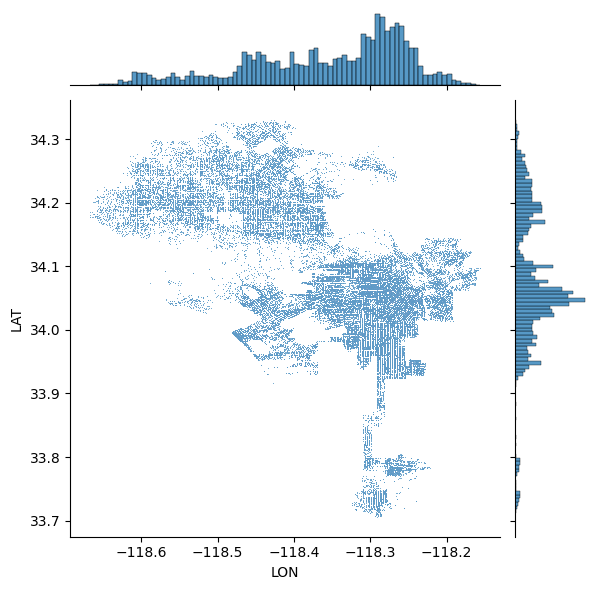

In [4]:
# use Seaborn package to Generate scatter plot
seaborn.jointplot(x="LON", y="LAT", data=gdb, s=0.5);

contextily is a Python package used to add basemaps (background maps) to geospatial data visualizations in Matplotlib and Geopandas plots. It works by fetching web tiles from online map providers (e.g., OpenStreetMap, Stamen, Carto) and overlaying them onto geospatial plots.

Official Documentation: https://contextily.readthedocs.io/

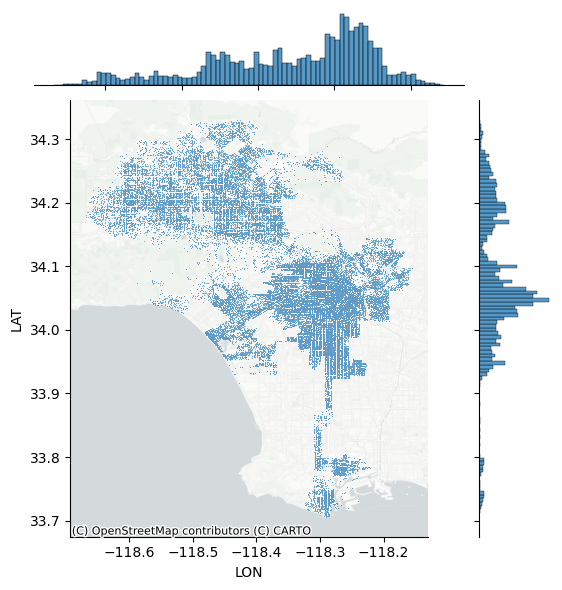

In [5]:
# Use the contextlity to add basemaps
joint_axes = seaborn.jointplot(
    x="LON", y="LAT", data=gdb, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

To reduce clutter, we can turn point data into a spatial histogram by dividing the area into a regular grid (squares or hexagons) and counting how many points fall into each cell. This works like a choropleth map, making patterns easier to see.
Hexagonal binning (hexbin) is often better than square grids because it reduces shape distortion and creates a more uniform connection between cells. This method provides a clear and intuitive way to visualize dense point data.

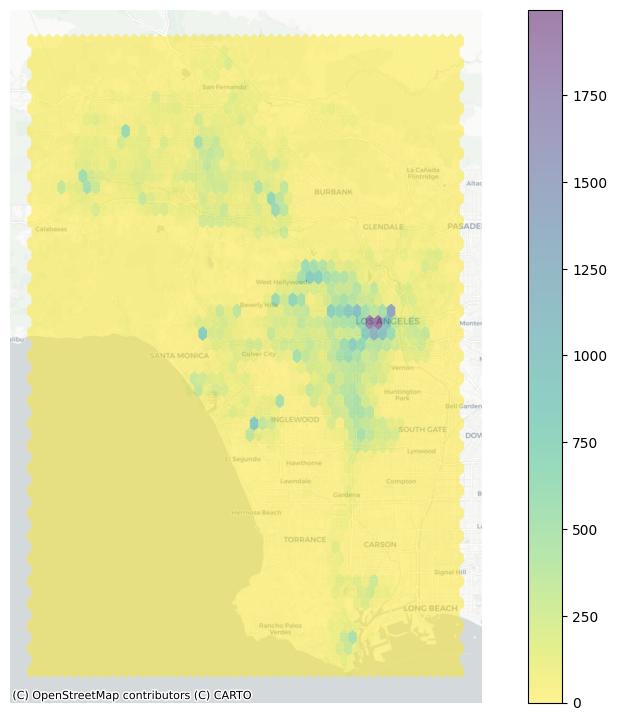

In [6]:
## Showing density with hexbinning
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    gdb["x"],
    gdb["y"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

An alternative is kernel density estimation (KDE), which creates a smooth surface instead of rigid bins. Instead of just counting points in squares, KDE places "kernels" (small weighting functions) over a grid and gives nearby points different weights based on distance. The most common kernel uses a normal distribution, creating a continuous heatmap of probability across the area.

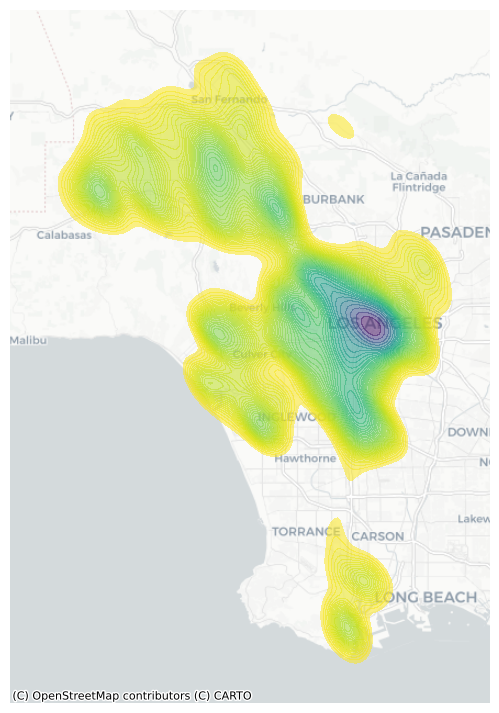

In [7]:
# kernel density estimation
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    x="x",
    y="y",
    data=gdb,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

Centrography is the study of centrality in a point pattern, focusing on its overall location and spread. It works like finding the "average" of a set of points, similar to how a mean summarizes numerical data. This method helps simplify complex spatial distributions by summarizing them with key measures, such as the central point, the tightness of clustering, and the overall shape of the pattern.

In [8]:
from pointpats import centrography

In [9]:
mean_center = centrography.mean_center(gdb[["x", "y"]])
med_center = centrography.euclidean_median(gdb[["x", "y"]])

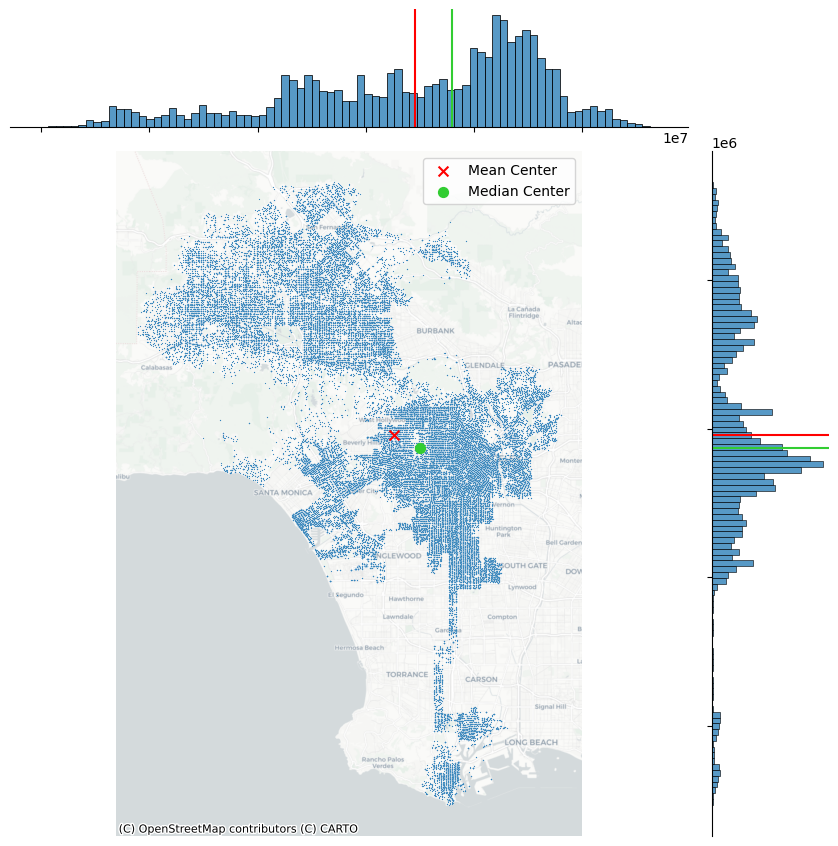

In [10]:
# Generate scatterplot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=gdb, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

Dispersion describes how spread out points are around the center. A common measure is standard distance, which calculates the average distance of points from the center (like the center of mass). This helps show how tightly or loosely points are clustered. You can easily compute this using the std_distance function in pointpats

In [11]:
centrography.std_distance(gdb[["x", "y"]])

19026.90572219582

Another useful way to visualize dispersion is the standard deviational ellipse (or standard ellipse). This ellipse shows the center, spread, and direction of the point pattern. You can create it using the ellipse function in pointpats

In [12]:
major, minor, rotation = centrography.ellipse(gdb[["x", "y"]])

In [13]:
major

11773.983260314046

In [14]:
minor

14521.04858577387

In [15]:
rotation

-0.5785043360749267

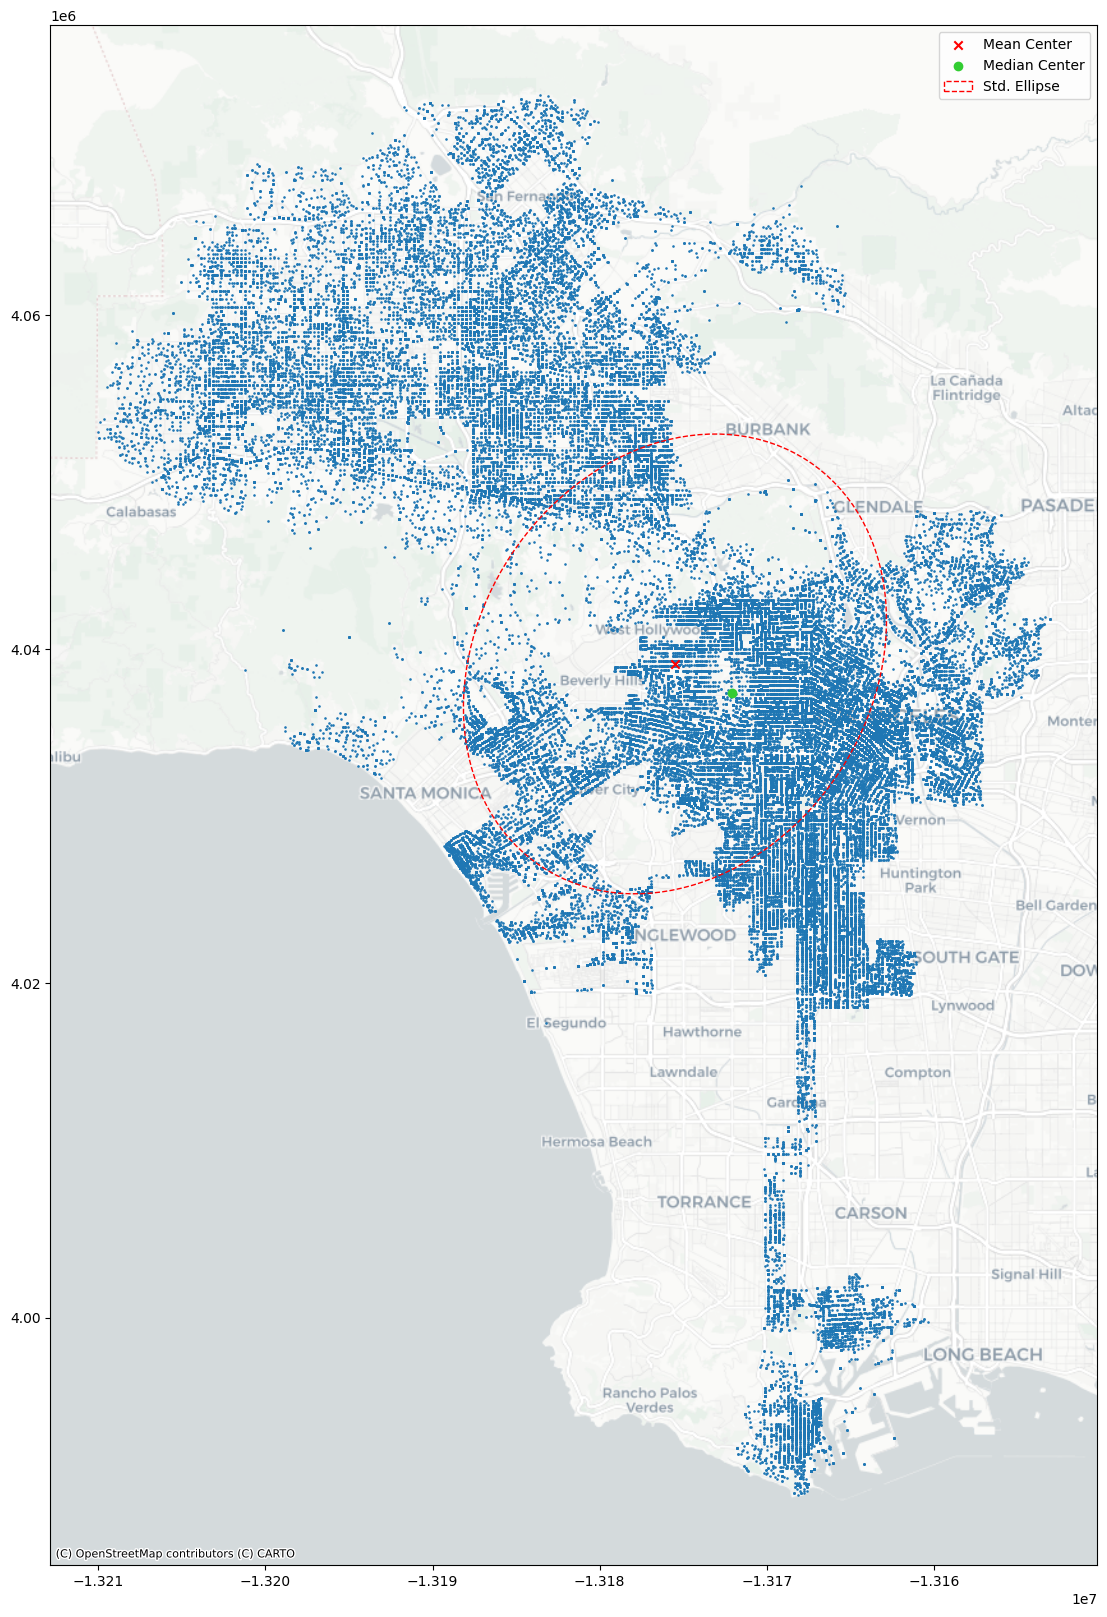

In [16]:
# Construct the standard ellipse using matplotlib
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))
# Plot photograph points
ax.scatter(gdb["x"], gdb["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=numpy.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
plt.show()

There are five shapes to evaluate the extent of a point of cloud: 
1. Alpha Shape
2. Minimum Rotated Rectangle
3. Convex Hull
4. Min Bounding Rectangle
5. Min Bounding Circle
Each shape captures a different level of tightness around the points to measure how spread out a point cloud is.

next, We'll show how to create each shape and compare them using a sub dataset(robbery) of the crime points.

In [54]:
# Rename the column
gdb = gdb.rename(columns={"Crm Cd": "Crm_Cd"})  


In [55]:
# query for robbery
robbery = gdb.query("Crm_Cd == 210") 

coordinates = robbery[["x", "y"]].values

The convex hull is the smallest shape that fully encloses the locations of the robbery. A convex shape has no inward curves or gaps, and all of its interior angles are less than 180 degrees. This is calculated using the centrography.hull method.

In [20]:
convex_hull_vertices = centrography.hull(coordinates)

An alpha shape is a "tighter" version of the convex hull. Imagine a convex hull as the space left by rolling a huge ball around the shape. The ball is so big that it doesn't fit into the gaps and just creates straight lines. An alpha shape, on the other hand, is like rolling a smaller ball around the shape. This smaller ball fits into the dips and valleys between points, making the shape tighter. As the ball gets bigger, the alpha shape turns into the convex hull. If the ball gets too small, the shape can break into multiple parts. To avoid this, the libpysal package has an alpha_shape_auto function that finds the best size for the ball automatically.

In [21]:
import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(
    coordinates, return_circles=True
)

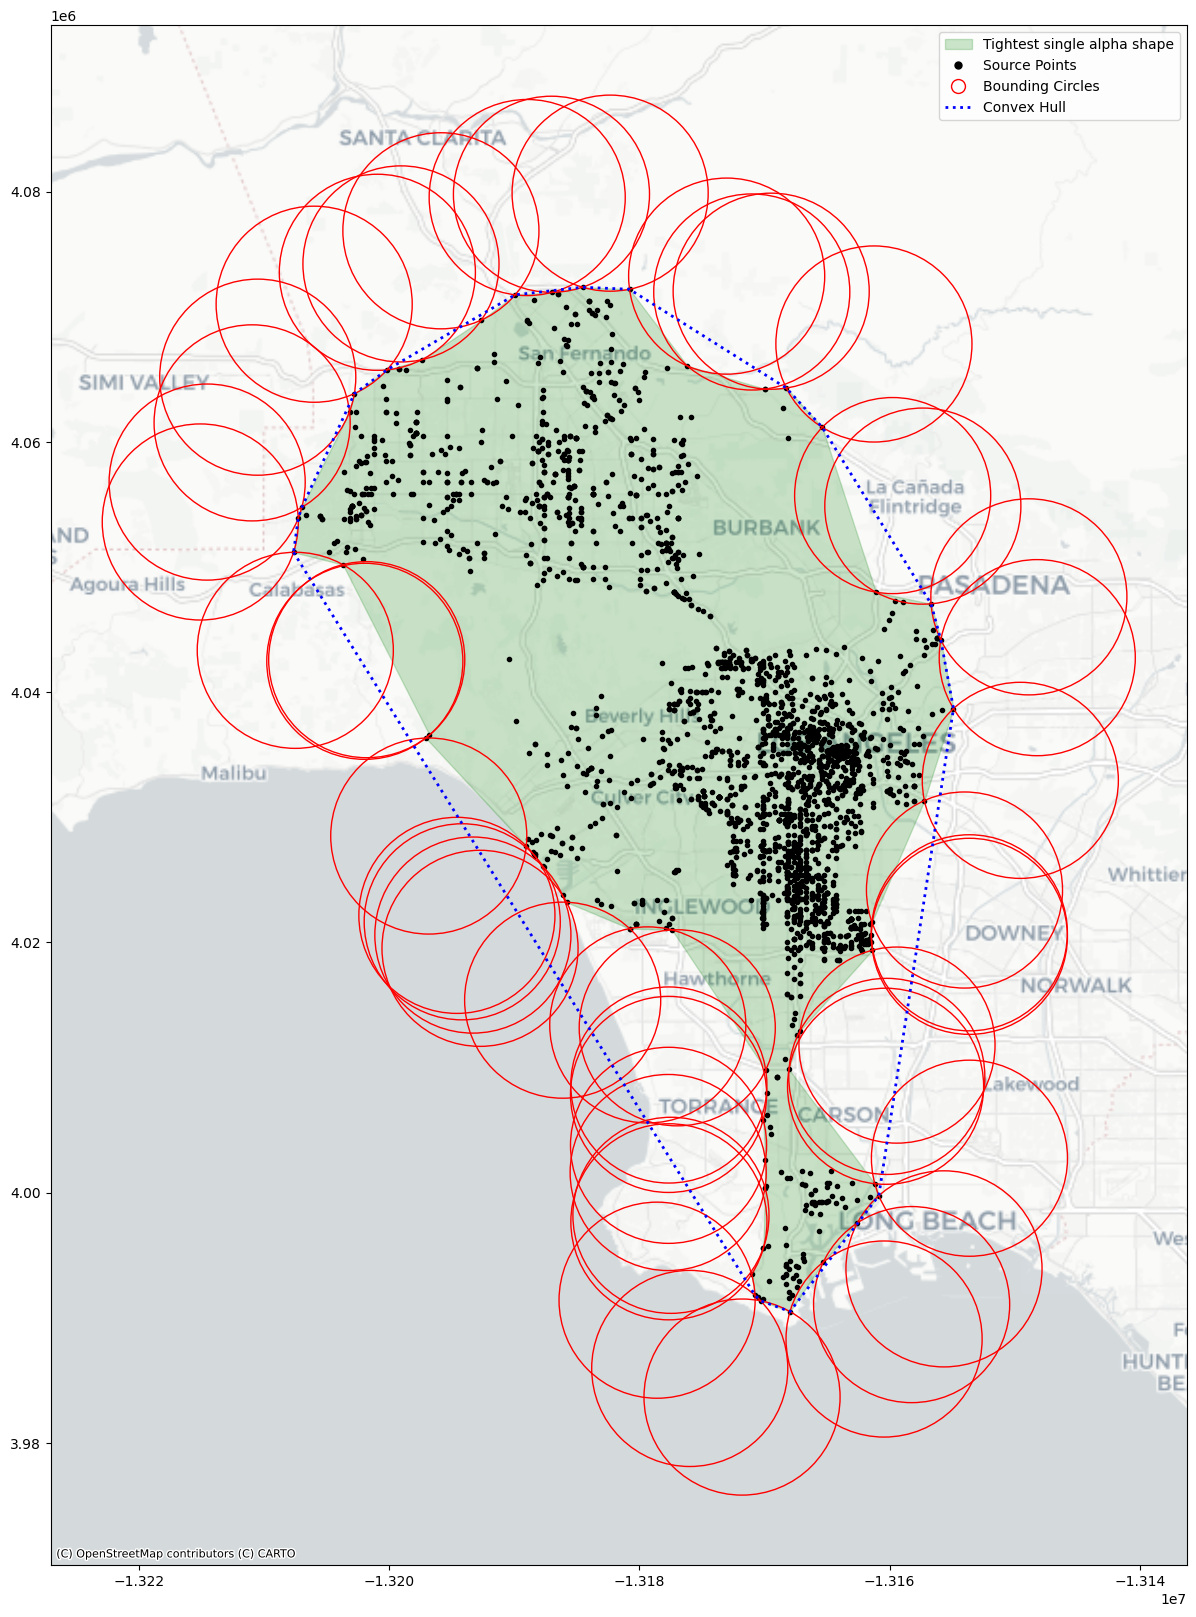

In [22]:


f, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot a green alpha shape
alpha_plot = geopandas.GeoSeries([alpha_shape]).plot(
    ax=ax, edgecolor="green", facecolor="green", alpha=0.2, label="_nolabel_"
)

# Include the points for our prolific user in black
points_plot = ax.scatter(*coordinates.T, color="k", marker=".", label="Source Points")

# Plot the circles forming the boundary of the alpha shape
circle_patches = []
for circle in circs:
    circ_patch = Circle(circle, radius=alpha, facecolor="none", edgecolor="r")
    ax.add_patch(circ_patch)
    circle_patches.append(circ_patch)

# Add a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices, closed=True, edgecolor="blue",
    facecolor="none", linestyle=":", linewidth=2
)
ax.add_patch(convex_hull_patch)

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

#  **Manually Define Legend Using the Original Symbols**
legend_elements = [
    Patch(facecolor="green", edgecolor="green", alpha=0.2, label="Tightest single alpha shape"),  # Alpha Shape
    Line2D([], [], color="black", marker=".", linestyle="None", markersize=10, label="Source Points"),  # Black Dots
    Line2D([], [], color="red", marker="o", linestyle="None", markersize=10, markerfacecolor="none", label="Bounding Circles"),  # Red Circles
    Line2D([], [], color="blue", linestyle=":", linewidth=2, label="Convex Hull"),  # Blue Convex Hull
]

ax.legend(handles=legend_elements, loc="upper right")

plt.show()


To calculate the minimum rotated rectangle, we’ll use the minimum_rotated_rectangle function from the pygeos module. This function finds the smallest rectangle that can surround our points, even if it's rotated. First, we'll group all the points into a single multi-point object and then calculate the rotated rectangle for that group.

In [23]:
from pygeos import minimum_rotated_rectangle, from_shapely, to_shapely

point_array = geopandas.points_from_xy(x=robbery.x, y=robbery.y)

min_rot_rect = minimum_rotated_rectangle(
    from_shapely(
        point_array.unary_union()
    )
)
min_rot_rect = to_shapely(min_rot_rect)

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygeos\io.py:89: UserWarning: The shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


In [24]:
min_rect_vertices = centrography.minimum_bounding_rectangle(
    coordinates
)

In [25]:
min_rect_vertices 

(-13207634.568556894,
 3990503.707557406,
 -13154891.393819042,
 4072363.7664709683)

In [26]:
(center_x, center_y), radius = centrography.minimum_bounding_circle(
    coordinates
)

In [27]:
from matplotlib.patches import Polygon, Circle, Rectangle

# Make a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull",
)

# compute the width and height of the minimum bounding rectangle
min_rect_width = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_height = min_rect_vertices[3] - min_rect_vertices[1]

# Make a goldenrod minimum bounding rectangle
min_rect_patch = Rectangle(
    min_rect_vertices[0:2],
    width=min_rect_width,
    height=min_rect_height,
    edgecolor="goldenrod",
    facecolor="none",
    linestyle="dashed",
    linewidth=2,
    label="Min Bounding Rectangle",
)

# and make a red minimum bounding circle
circ_patch = Circle(
    (center_x, center_y),
    radius=radius,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    label="Min Bounding Circle",
)

In [28]:
min_rect_width 

52743.17473785207

In [29]:
min_rect_height

81860.05891356245

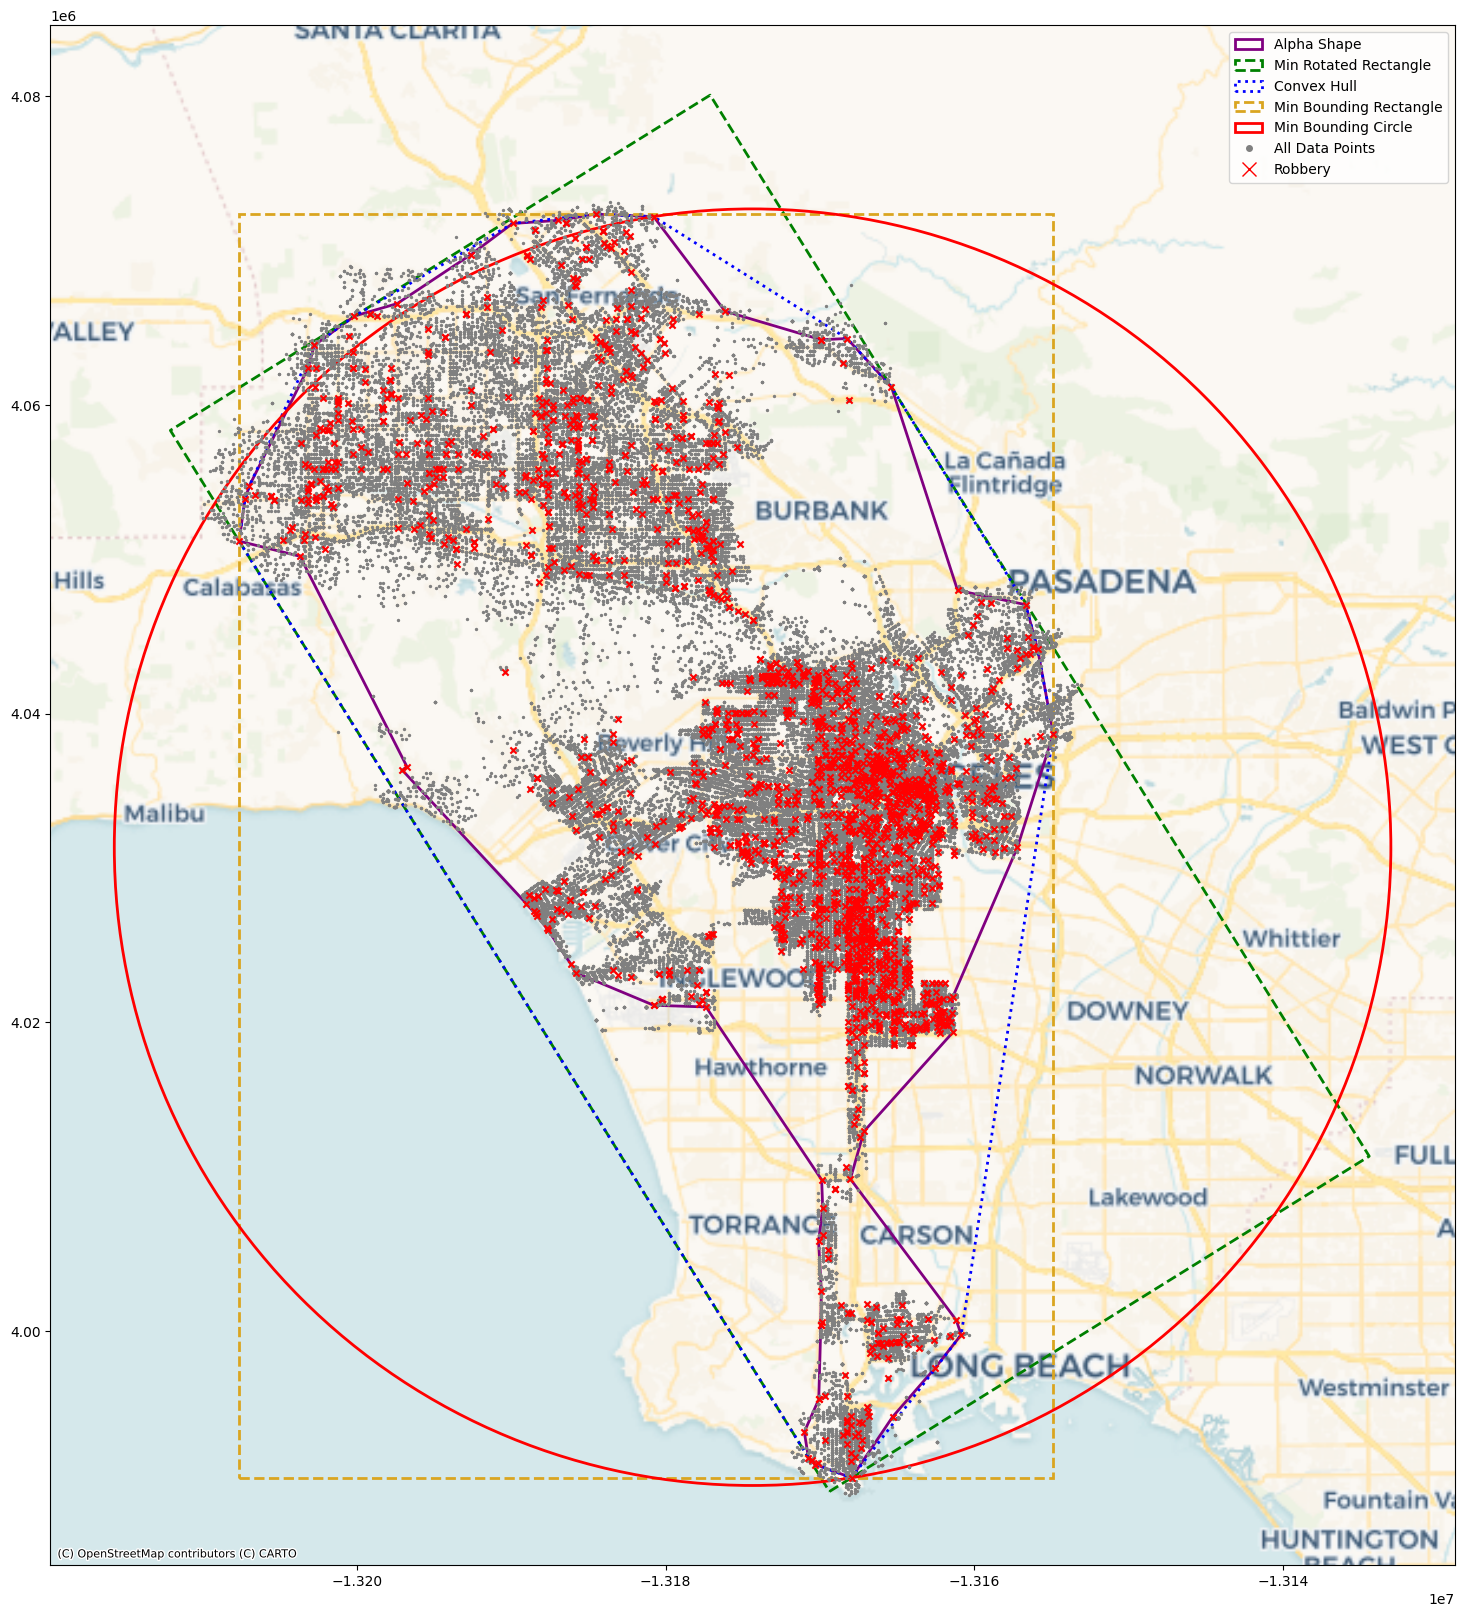

In [30]:


f, ax = plt.subplots(1, figsize=(20, 20))

# Plot Alpha Shape (purple)
geopandas.GeoSeries([alpha_shape]).plot(
    ax=ax, edgecolor="purple", facecolor="none", linewidth=2
)

# Plot Minimum Rotated Rectangle (green)
geopandas.GeoSeries([min_rot_rect]).plot(
    ax=ax, edgecolor="green", facecolor="none", linestyle="--", linewidth=2
)

# Create patch instances
convex_hull_patch_new = Polygon(
    convex_hull_vertices, closed=True, edgecolor="blue", facecolor="none", linestyle=":", linewidth=2
)

min_rect_patch_new = Rectangle(
    min_rect_vertices[0:2], width=min_rect_width, height=min_rect_height,
    edgecolor="goldenrod", facecolor="none", linestyle="dashed", linewidth=2
)

circ_patch_new = Circle(
    (center_x, center_y), radius=radius, edgecolor="red", facecolor="none", linewidth=2
)

# Add patches to plot
ax.add_patch(convex_hull_patch_new)
ax.add_patch(min_rect_patch_new)
ax.add_patch(circ_patch_new)

# Scatter plot
ax.scatter(gdb.x, gdb.y, s=2, color="grey", label="_nolegend_")  # Hide default legend
ax.scatter(robbery.x, robbery.y, s=20, color="r", marker="x", label="_nolegend_")

# Manually create legend handles with original symbols
legend_handles = [
    mpatches.Patch(edgecolor="purple", facecolor="none", linewidth=2, label="Alpha Shape"),
    mpatches.Patch(edgecolor="green", facecolor="none", linestyle="--", linewidth=2, label="Min Rotated Rectangle"),
    mpatches.Patch(edgecolor="blue", facecolor="none", linestyle=":", linewidth=2, label="Convex Hull"),
    mpatches.Patch(edgecolor="goldenrod", facecolor="none", linestyle="dashed", linewidth=2, label="Min Bounding Rectangle"),
    mpatches.Circle((0, 0), radius=5, edgecolor="red", facecolor="none", linewidth=2, label="Min Bounding Circle"),
    mlines.Line2D([], [], color="grey", marker="o", linestyle="None", markersize=4, label="All Data Points"),
    mlines.Line2D([], [], color="red", marker="x", linestyle="None", markersize=10, label="Robbery"),
]

# Add custom legend with original symbols
ax.legend(handles=legend_handles, loc="upper right")

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Voyager)

plt.show()


Each shape gives a different view of the area around the locations of robbery. The alpha shape is the tightest, while the minimum bounding rectangle and circle are the loosest, covering more area outside the usual photo range. However, the rectangle and circle are the easiest shapes to draw and understand.

In [31]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [32]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

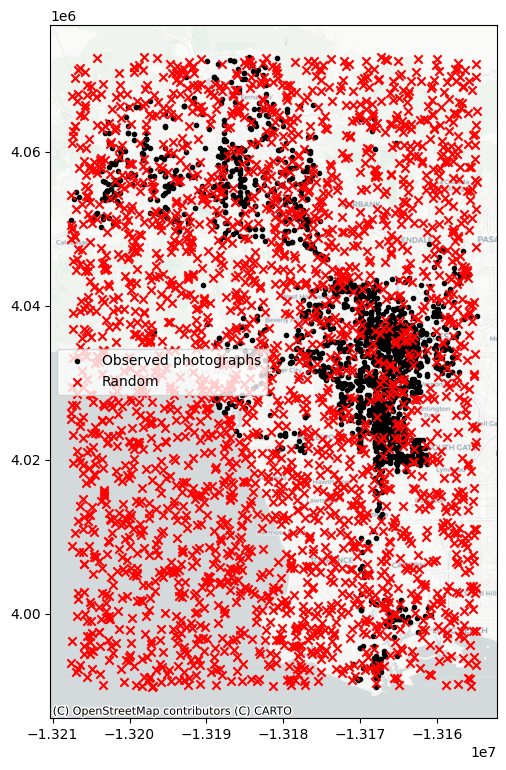

In [33]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observed photographs"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

In [34]:
random_pattern_ashape = random.poisson(
    alpha_shape, size=len(coordinates)
)

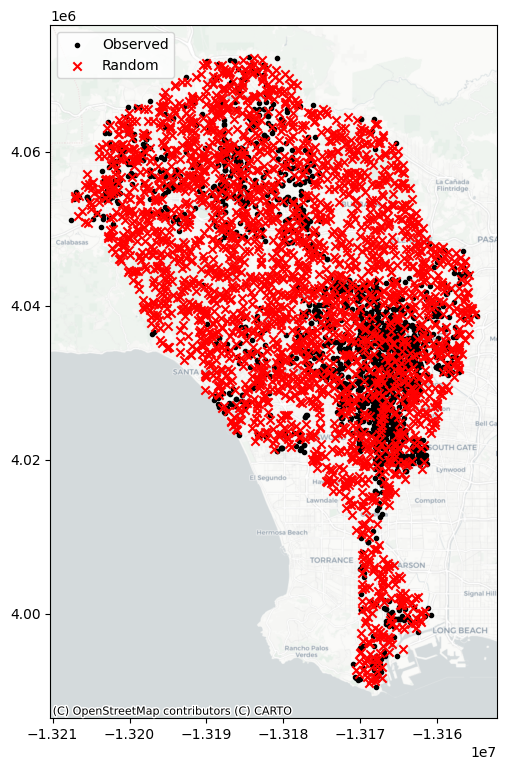

In [35]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(*coordinates.T, color="k", marker=".", label="Observed")
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Random"
)
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="upper left")
plt.show()

<Axes: title={'center': 'Quadrat Count'}>

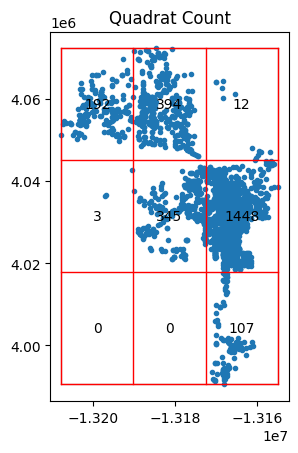

In [36]:
qstat = QStatistic(coordinates)
qstat.plot()

In [37]:
qstat.chi2_pvalue

0.0

<Axes: title={'center': 'Quadrat Count'}>

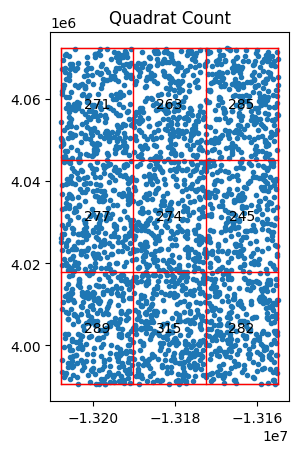

In [38]:

qstat_null = QStatistic(random_pattern)
qstat_null.plot()


In [39]:
qstat_null.chi2_pvalue

0.22781153410259397

<Axes: title={'center': 'Quadrat Count'}>

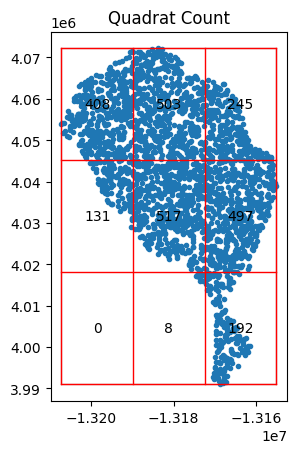

In [40]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()




In [41]:
random_pattern

array([[-13193518.13938109,   3991311.50785901],
       [-13169474.18930438,   4049648.39607619],
       [-13204719.43958291,   4027457.49969982],
       ...,
       [-13186658.96871983,   4065322.47340857],
       [-13186536.04577809,   4015182.61027408],
       [-13163430.4233688 ,   4002613.9953521 ]])

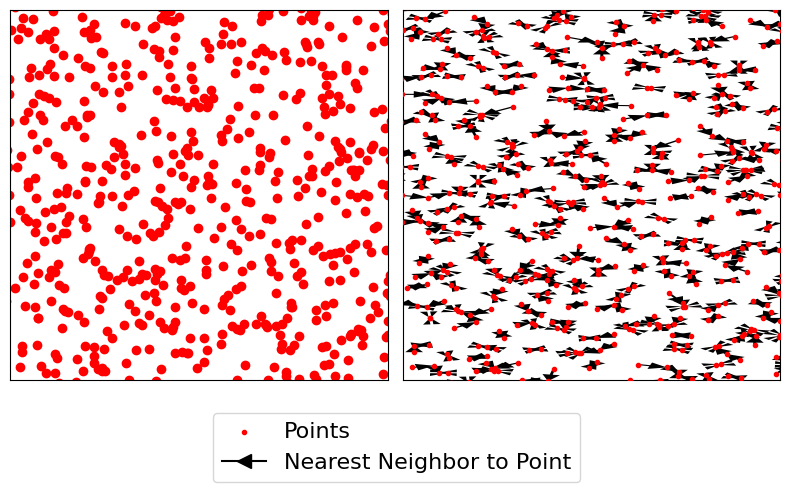

In [42]:
# Code generated for this figure is available on the web version of the book.
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color="red")
ax[1].scatter(
    *random_pattern.T,
    color="red",
    zorder=100,
    marker=".",
    label="Points"
)
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(
        *coord,
        dx,
        dy,
        length_includes_head=True,
        overhang=0,
        head_length=300 * 3,
        head_width=300 * 3,
        width=50 * 3,
        linewidth=0,
        facecolor="k",
        head_starts_at_zero=False
    )
    if first:
        plt.plot(
            (1e100, 1e101),
            (0, 1),
            color="k",
            marker="<",
            markersize=10,
            label="Nearest Neighbor to Point",
        )
    first = False

ax[0].axis([-13207339.63777211, -13188257.25703596, 3998020.06171111, 4048508.57847984])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor=(0.5, -0.06), fontsize=16)
plt.show()

In [43]:
g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)

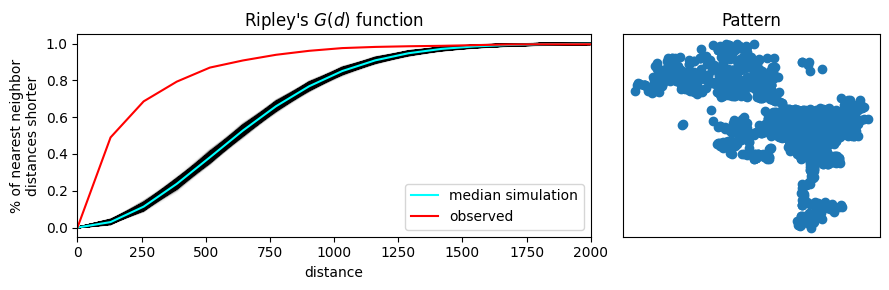

In [44]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    numpy.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

In [45]:
f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

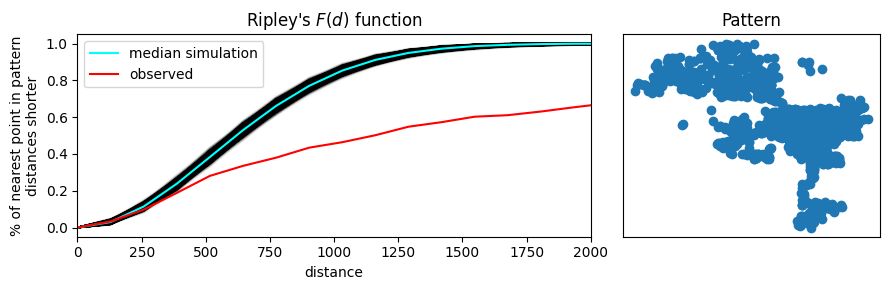

In [46]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    numpy.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's F function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

In [47]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(gdb[["x", "y"]])

DBSCAN()

In [48]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:5]

array([0, 3, 4, 5, 7], dtype=int64)

In [49]:
clusterer.labels_[:5]

array([ 0, -1, -1,  1,  2], dtype=int64)

In [50]:
lbls = pandas.Series(clusterer.labels_, index=gdb.index)

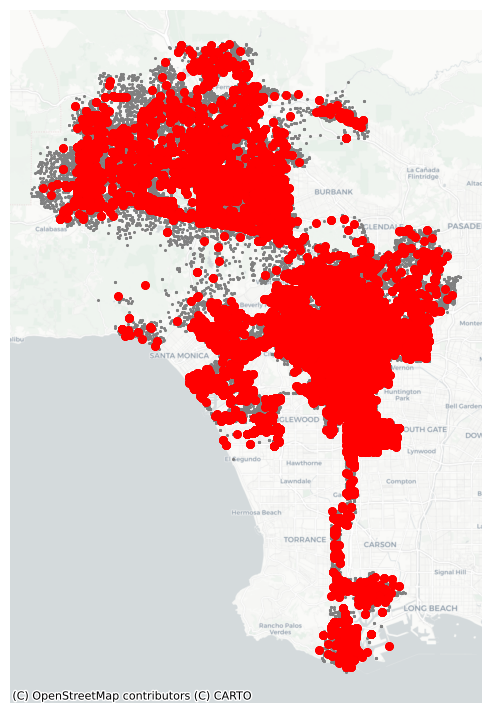

In [51]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = gdb.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    gdb.loc[gdb.index.difference(noise.index), "x"],
    gdb.loc[gdb.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

In [52]:
# Obtain the number of points 1% of the total represents
minp = numpy.round(gdb.shape[0] * 0.01)
minp

1275.0

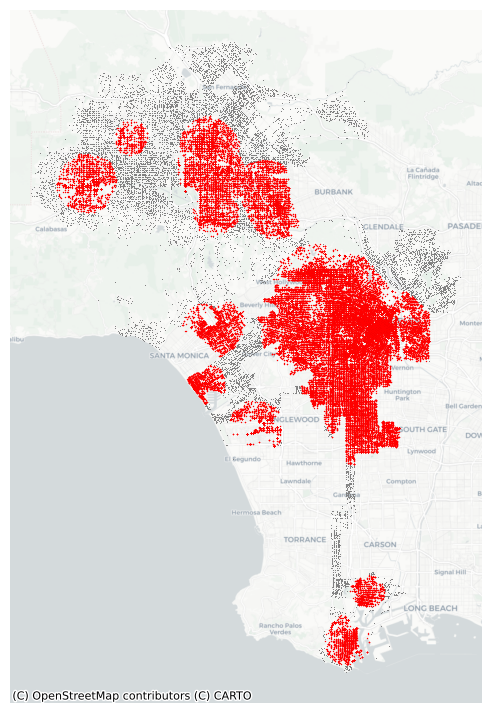

In [53]:
# Rerun DBSCAN
clusterer = DBSCAN(eps=2000, min_samples=int(minp))
clusterer.fit(gdb[["x", "y"]])
# Turn labels into a Series
lbls = pandas.Series(clusterer.labels_, index=gdb.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = gdb.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=0.5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    gdb.loc[gdb.index.difference(noise.index), "x"],
    gdb.loc[gdb.index.difference(noise.index), "y"],
    c="red",
    s=1,
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()